In [2]:
#!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [21]:
#!pip install torch
#!pip install webcolors

In [1]:
#!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...


In [5]:
#!pip install torchvision

In [1]:
import torch
import cv2
import csv
import webcolors
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from pathlib import Path

cardmodel = torch.hub.load('ultralytics/yolov5','custom',path ='C:/Users/97150/Desktop/Uno_card_color_shape_detection/Card_detection/yolov5/runs/train/exp/weights/best.pt',force_reload=True)
cardmodel.conf=0.50

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\97150/.cache\torch\hub\master.zip
YOLOv5  2023-4-27 Python-3.8.5 torch-2.0.0+cpu CPU

Fusing layers... 


requirements: C:\Users\97150\.cache\torch\hub\requirements.txt not found, check failed.


Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [2]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
imgpath='C:/Users/97150/Desktop/Uno_card_color_shape_detection/Card_detection/b.jpg'
img = cv2.imread(imgpath)
img1=img.copy()
results = cardmodel(img)
results.print()

fulllist=(results.pandas().xyxy[0])
#print('The number of people detected is :',sum(fulllist['name']=='person'))

cards=[]
bb_xy=results.xyxy[0].cpu().detach().numpy()
bb1_xy=bb_xy[bb_xy[:,-1]==0]
bb1_xy=bb1_xy.astype('int')
bb_x1y1=bb1_xy[:,0:2]
bb_x2y2=bb1_xy[:,2:4]

bb=results.xywh[0].cpu().detach().numpy()
bb1=bb[bb[:,-1]==0]
bb1=bb1.astype('int')
bb_wh=bb1[:,2:4]
th=int(0.01*img.shape[0]*img.shape[1])
cropped_img = img[bb_x1y1[0,1]:bb_x1y1[0,1]+bb_wh[0,1],bb_x1y1[0,0]:bb_x1y1[0,0]+bb_wh[0,0]]
cv2.imwrite('p.png',cropped_img)

image 1/1: 1920x1080 1 card
Speed: 6.0ms pre-process, 352.2ms inference, 2.0ms NMS per image at shape (1, 3, 640, 384)


True

In [3]:
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return closest_name
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    
    # return the bar chart
    return bar

cornflowerblue
[[[116 161 220]]]


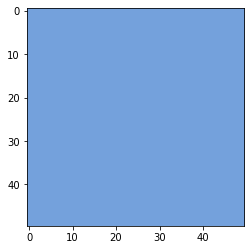

Using median values
[[[116 158 222]]]
cornflowerblue


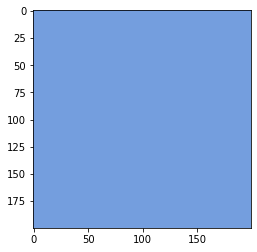

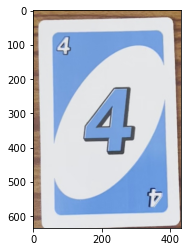

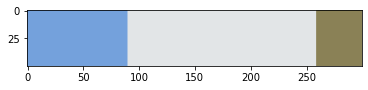

In [8]:
%matplotlib inline
col_res=pd.DataFrame()
res11=[]
v1=cv2.imread('p.png')
image = cv2.cvtColor(v1, cv2.COLOR_BGR2HSV)

## reshape the image to be a list of pixels
image = image.reshape((image.shape[0] * image.shape[1], 3))
# cluster the pixel intensities
clt = KMeans(n_clusters = 3)
clt.fit(image)

big_clust=pd.DataFrame(clt.labels_).value_counts().index[1][0]
cent=clt.cluster_centers_[big_clust,:].astype(int)

col=np.array([[cent]]).astype('uint8')
col1=cv2.cvtColor(col,cv2.COLOR_HSV2RGB)

print(get_colour_name(col1[0][0]))
print(col1)
bar = np.zeros((50, 50, 3), dtype = "uint8")
#cc=cv2.rectangle(bar,(0,0),(50,50),cent.astype("uint8").tolist(), -1)
cc=cv2.rectangle(bar,(0,0),(50,50),col1[0][0].tolist(), -1)

plt.imshow(cc)
plt.show()

# print(get_colour_name(cent))
# print(cent)
print('Using median values')
data=pd.DataFrame(image)
data['label']=clt.labels_
rgb_median=np.array(data[data['label']==big_clust].median()[:3])
col_med=np.array([[rgb_median]]).astype('uint8')
col_med=cv2.cvtColor(col_med,cv2.COLOR_HSV2RGB)
print(col_med)
print(get_colour_name(col_med[0][0]))

bar = np.zeros((200, 200, 3), dtype = "uint8")
#cc=cv2.rectangle(bar,(0,0),(50,50),cent.astype("uint8").tolist(), -1)
ccc=cv2.rectangle(bar,(0,0),(200,200),col_med[0][0].tolist(), -1)

plt.imshow(ccc)
plt.show()


cen=cv2.cvtColor(np.array([clt.cluster_centers_]).astype('uint8'),cv2.COLOR_HSV2RGB)
hist = centroid_histogram(clt)
#hist=np.sort(hist)[::-1]
bar1 = plot_colors(hist, cen[0])


plt.imshow(cv2.cvtColor(v1, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(bar1)
plt.show()



